![](https://i.imgur.com/eBRPvWB.png)

##**Generowanie poezji za pomocą RNN i PyTorch sylabami**

[W tutorialu na rozgrzewkę](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) użyliśmy RNN, aby sklasyfikować nazwiska znak po znaku. Tym razem wygenerujemy tekst sylaba po sylabie.
```
Litwo! Ojczyzno moja! ty jesteś klucz wyziemu, 
To opugo cząciły tak lasu czeleta. 
Choć nie będzie mowę świeci się za tém, 
A Dozgon++ na Litwę przerzucił w okolicy, 
Dosyć się opicie przyciągnąć w pałacu; 

Tamdzini nawet mimo osobnych ogórki. 
Choć zwyciętunia, mimo pukle wyślą, 
Odemknął, wbiegł wyszedł, pewnie miłośnik łowił. 
Bo przekorza, i skrobiąc nabój do Warszawy. 
Dość co oddało plecie tak fawował, 
A tam się cukier wytaczać na nich wybująca. 

```

Ok, możesz zadać sobie pytanie, czy ten tutorial jest rzeczywiście praktyczny? Czemu nie? Modele generatywne tego typu stanowią fundament tłumaczenia maszynowego, opisywania obrazów, generowania odpowiedzi na pytania i wielu innych zastowań.

Zobacz [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) żeby nauczyć się więcej w tym temacie.

## Polecana lektura

Zakładam, że jest już zainstalowany PyTorch, znasz Python'a, oraz znasz pojęcie Tensor'ów:

* http://pytorch.org/ - instalacja PyTorch
* [Deep Learning with PyTorch: A 60-minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) - Podstawy PyTorch
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) przykłady wykorzystania PyTorch
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) jeżeli znasz Lua Torch

Trochę wiedzy o RNN:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) przykłady z życia wzięte
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) RNN i LSTM w pigułce

Zobacz także podobne tutoriale z serii:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) używa RNN do klasyfikacji
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) opierając się na tym modelu, dodaje kategorię jako dane wejściowe

# Ustawianie środowiska pod syllable-RNN

## Instalacja PyTorch

In [ ]:
# # http://pytorch.org/
# from os import path
# # from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

## Instalacja bibliotek

In [1]:
!pip install -q scipy --upgrade

     |████████████████████████████████| 25.9MB 122kB/s 
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install -q unidecode tqdm dill pysmi visdom

     |████████████████████████████████| 245kB 8.5MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 686kB 14.5MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 204kB 23.6MB/s 


## Instalacja biblioteki PyDrive i wrappera

In [18]:
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
import os

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())
      
  print(f'Saved {file_name}')
  
FILE_NAME, FILE_ID = ['file_name', 'file_id']

## Pobranie i instalacja stemmera

!dpkg --add-architecture i386
!apt-get -qq update
!apt-get -qq install libc6:i386 libncurses5:i386 libstdc++6:i386

In [19]:
# stemmer-2.0.3.tgz, https://drive.google.com/file/d/1PxS-e6tzXa7u4N9A2r9XWLUpvSKqJIrZ
stemmer = {FILE_NAME: 'stemmer-2.0.3.tgz', FILE_ID: '1PxS-e6tzXa7u4N9A2r9XWLUpvSKqJIrZ'}
stemmer_path = Path('./') / stemmer[FILE_NAME]
download_and_save(stemmer_path, stemmer[FILE_ID])

Saved stemmer-2.0.3.tgz


In [20]:
!tar xzf $stemmer_path

In [21]:
ls -lah bin

total 8.2M
drwxr-xr-x 2  501 staff 4.0K Apr 30  2018 ./
drwxr-xr-x 1 root root  4.0K Nov 28 17:09 ../
-rw-r--r-- 1  501 staff 1.2K Apr 19  2018 changelog.txt
-rwxr-xr-x 1  501 staff  629 Jan  2  2018 destem.sh*
-rw-r--r-- 1  501 staff 858K Nov 22  2017 stemmer2.dic
-rwxrwxr-x 1  501 staff 3.7M Apr 19  2018 stemmer.linux*
-rwxr-xr-x 1  501 staff 3.6M Apr 30  2018 stemmer.macos*


# Pobranie danych

In [ ]:
from pathlib import Path
dataset_path = Path('/content/data/rnn_generator'); dataset_path
!mkdir -p $dataset_path
!ls -la $dataset_path/
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

total 8
drwxr-xr-x 2 root root 4096 Nov 27 14:48 .
drwxr-xr-x 3 root root 4096 Nov 27 14:48 ..


## Pobranie datasetu Pan Tadeusz

In [ ]:
# pan_tadeusz, https://drive.google.com/open?id=1l8KGrqUsrGOlXVp7Frgyku8w75X_WA8h
pan_tadeusz = {FILE_NAME: 'pan_tadeusz.txt', FILE_ID: '1l8KGrqUsrGOlXVp7Frgyku8w75X_WA8h'}

download_and_save(dataset_path / pan_tadeusz[FILE_NAME], pan_tadeusz[FILE_ID])

Saved /content/data/rnn_generator/pan_tadeusz.txt


In [ ]:
ls -la $dataset_path/

total 232
drwxr-xr-x 3 root root   4096 Nov 27 14:48 ./
drwxr-xr-x 3 root root   4096 Nov 27 14:48 ../
-rw-r--r-- 1 root root 223706 Nov 27 14:48 pan_tadeusz.txt
drwxr-xr-x 2 root root   4096 Nov 27 14:48 tmp/


# Opcjonalne

## Opcjonalne pobranie innych datasetów

In [ ]:
# witkacy_szewcy, https://drive.google.com/open?id=1NOWTocYwv93GibItaNBxTJobjTukQmRP
witkacy = {FILE_NAME: 'witkacy_szewcy.txt', FILE_ID: '1NOWTocYwv93GibItaNBxTJobjTukQmRP'}

download_and_save(dataset_path / witkacy[FILE_NAME], witkacy[FILE_ID])

Saved /content/data/rnn_generator/witkacy_szewcy.txt


In [ ]:
# mickiewicz, https://drive.google.com/open?id=1otbOB7GjKEVPjaPShaaTnYQnv-whwNWP
mickiewicz = {FILE_NAME: 'mickiewicz.txt', FILE_ID: '1otbOB7GjKEVPjaPShaaTnYQnv-whwNWP'}

download_and_save(dataset_path / mickiewicz[FILE_NAME], mickiewicz[FILE_ID])

Saved /content/data/rnn_generator/mickiewicz.txt


In [ ]:
!ls -la $dataset_path/

total 1088
drwxr-xr-x 3 root root   4096 Nov 27 14:50 .
drwxr-xr-x 3 root root   4096 Nov 27 14:48 ..
-rw-r--r-- 1 root root 725495 Nov 27 14:50 mickiewicz.txt
-rw-r--r-- 1 root root 223706 Nov 27 14:48 pan_tadeusz.txt
drwxr-xr-x 2 root root   4096 Nov 27 14:48 tmp
-rw-r--r-- 1 root root 145132 Nov 27 14:50 witkacy_szewcy.txt


## Opcjonalne pobranie przetrenowanego modelu

In [ ]:
# all_tokens.n5059.pan_tadeusz.p, https://drive.google.com/open?id=14AxyK--ifqyzwThw712jHid7NVaLqAC3
# pan_tadeusz.h500.l3.20.gpu.torch, https://drive.google.com/open?id=1NF-bmLgsAC6l_Fdlr7xZ1_i3e_5EgIYG
ALLTOKS, MODEL = ['all_tokens', 'model']
fn_pan_tadeusz = {ALLTOKS: 'all_tokens.n5059.pan_tadeusz.p', MODEL: 'pan_tadeusz.h500.l3.e20.gpu.torch'}
ids_pan_tadeusz = {ALLTOKS: '14AxyK--ifqyzwThw712jHid7NVaLqAC3', MODEL: '1NF-bmLgsAC6l_Fdlr7xZ1_i3e_5EgIYG'}
download_and_save(tmp_path / fn_pan_tadeusz[ALLTOKS], ids_pan_tadeusz[ALLTOKS])
download_and_save(tmp_path / fn_pan_tadeusz[MODEL], ids_pan_tadeusz[MODEL])

Saved /content/data/rnn_generator/tmp/all_tokens.n5059.pan_tadeusz.p
Saved /content/data/rnn_generator/tmp/pan_tadeusz.h500.l3.e20.gpu.torch


In [ ]:
# all_tokens.n4064.witkacy_szewcy.p, https://drive.google.com/open?id=1hXWaH1vwciJqDh4mRA9R1B6ePapORCTc
# witkacy_szewcy.h500.l3.e11.gpu.torch, https://drive.google.com/open?id=1DegovTSmaNEyFM3AS8JZZnp7STO49IRp
ALLTOKS, MODEL = ['all_tokens', 'model']
fn_pan_tadeusz = {ALLTOKS: 'all_tokens.n4064.witkacy_szewcy.p', MODEL: 'witkacy_szewcy.h500.l3.e11.gpu.torch'}
ids_pan_tadeusz = {ALLTOKS: '1hXWaH1vwciJqDh4mRA9R1B6ePapORCTc', MODEL: '1DegovTSmaNEyFM3AS8JZZnp7STO49IRp'}
download_and_save(tmp_path / fn_pan_tadeusz[ALLTOKS], ids_pan_tadeusz[ALLTOKS])
download_and_save(tmp_path / fn_pan_tadeusz[MODEL], ids_pan_tadeusz[MODEL])

Saved /content/data/rnn_generator/tmp/all_tokens.n4064.witkacy_szewcy.p
Saved /content/data/rnn_generator/tmp/witkacy_szewcy.h500.l3.e11.gpu.torch


In [ ]:
ls -lah $tmp_path

total 2.8M
drwxr-xr-x 1 root root  4.0K Nov 27 17:55 ./
drwxr-xr-x 1 root root  4.0K Nov 27 17:53 ../
-rw-r--r-- 1 root root   720 Nov 27 17:54 adc.json
drwxr-xr-x 2  501 staff 4.0K Apr 30  2018 bin/
drwxr-xr-x 1 root root  4.0K Nov 27 17:54 .config/
drwxr-xr-x 2 root root  4.0K Nov 27 17:55 .ipynb_checkpoints/
drwxr-xr-x 4 root root  4.0K Nov 27 17:55 rnn_generator/
drwxr-xr-x 1 root root  4.0K Nov 13 17:33 sample_data/
-rw-r--r-- 1 root root  2.7M Nov 27 17:54 stemmer-2.0.3.tgz


# Monitorowanie maszyny wirtualnej

In [ ]:
!uptime
!nvidia-smi

 17:55:59 up 3 min,  0 users,  load average: 0.08, 0.15, 0.07
Fri Nov 27 17:55:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                          

## Załadowanie bibliotek

In [3]:
!pip install torch==1.3.0
from pathlib import Path
import platform
import string
import random
import re
from IPython.core.display import display, HTML
import os
import psutil
import pickle
import warnings
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('bmh')


     |████████████████████████████████| 773.1MB 22kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


## Preprocessing korpusu

In [4]:
dataset_path = Path('data/rnn_generator'); dataset_path
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [6]:
ls -lah $dataset_path/

total 544K
drwxr-xr-x 3 root root 4.0K Nov 28 17:06 ./
drwxr-xr-x 3 root root 4.0K Nov 28 17:00 ../
drwxr-xr-x 2 root root 4.0K Nov 28 17:00 tmp/
-rw-r--r-- 1 root root 529K Nov 28 17:06 zwyczajne-zycie.txt


In [7]:
fn_corpus_char = dataset_path/'zwyczajne-zycie.txt'
fn_corpus_caps = dataset_path/'zwyczajne-zycie.caps1.txt'
fn_corpus_syl = dataset_path/'zwyczajne-zycie.syl1.txt'

Plik wejściowy (korpus) to duży plik tekstowy. 

In [8]:
!head -n 21 $fn_corpus_char


Joanna Chmielewska


Zwyczajne życie


W dość wczesnych godzinach sierpniowego, cichego, niedzielnego popołudnia Tereska Kępińska siedziała przy biurku w swoim pokoju i patrzyła w okno oczami pełnymi rozpaczy. Za oknem, w sennym upale, trwały nieruchomo zalane słońcem lipy, słoneczniki zwieszały swoje ciężkie, dojrzałe łby, świat wydawał się nasycony latem, spokojny, zadowolony z życia, i posępna rozpacz w oczach Tereski nieprzyjemnie kontrastowała z tą rozleniwioną, słoneczną pogodą.

Wnętrze pokoju kontrastowało z nią również. Na biurku, krzesłach i podłodze trwał w bezruchu potężny śmietnik, składający się w największej mierze z wytworów przemysłu papierniczego. Puste szuflady biurka były z jednej strony wysunięte, z drugiej całkowicie powyjmowane; stojący pod ścianą tapczan nieforemnym stosem pokrywały zdjęte z regału książki i rozsypane odbitki fotograficzne, z półki regału malowniczo zwisała imponujących rozmiarów ścierka od kurzu, na środku podłogi zaś stała wielka miednica z w

### Tokenizacja wielkich liter

Zamieniamy duże litery na małe dodając tokeny `_up_` (dla wyrazów pisanych wielkimi literami) lub `_cap_` (dla wyrazów pisanych z wielkiej litery).

In [9]:
def do_caps(ss):
  TOK_UP,TOK_CAP = ' _up_ ', ' _cap_ '
  res = []
  re_word = re.compile('\w')
  for s in re.findall(r'\w+|\W+', ss):
      res += ([TOK_UP,s.lower()] if (s.isupper() and (len(s)>2))
              else [TOK_CAP,s.lower()] if s.istitle()
              else [s.lower()])
  return ''.join(res)

In [10]:
corpus_tmp = fn_corpus_char.open('r').read()
corpus_tmp = do_caps(corpus_tmp)
fn_corpus_caps.open('w').write(corpus_tmp)

557353

In [11]:
!head -n 21 $fn_corpus_caps


 _cap_ joanna  _cap_ chmielewska


 _cap_ zwyczajne życie


 _cap_ w dość wczesnych godzinach sierpniowego, cichego, niedzielnego popołudnia  _cap_ tereska  _cap_ kępińska siedziała przy biurku w swoim pokoju i patrzyła w okno oczami pełnymi rozpaczy.  _cap_ za oknem, w sennym upale, trwały nieruchomo zalane słońcem lipy, słoneczniki zwieszały swoje ciężkie, dojrzałe łby, świat wydawał się nasycony latem, spokojny, zadowolony z życia, i posępna rozpacz w oczach  _cap_ tereski nieprzyjemnie kontrastowała z tą rozleniwioną, słoneczną pogodą.

 _cap_ wnętrze pokoju kontrastowało z nią również.  _cap_ na biurku, krzesłach i podłodze trwał w bezruchu potężny śmietnik, składający się w największej mierze z wytworów przemysłu papierniczego.  _cap_ puste szuflady biurka były z jednej strony wysunięte, z drugiej całkowicie powyjmowane; stojący pod ścianą tapczan nieforemnym stosem pokrywały zdjęte z regału książki i rozsypane odbitki fotograficzne, z półki regału malowniczo zwisała imponującyc

### Podział korpusu na sylaby

Dzielimy korpus na sylaby programem `stemmer`.

In [22]:
platform_suffixes = {'Linux': 'linux', 'Darwin': 'macos'}
platform_suffix = platform_suffixes[platform.system()]
stemmer_bin = f'LD_PRELOAD="" bin/stemmer.{platform_suffix}'

In [23]:
!$stemmer_bin --help


Stemmer 2.0.3 2018-04-19 (Linux i386)
For Korrida database, spellchecker and hyphenator copyright (C) 1993-2018 Wojciech Czarnowski
For Stemmer copyright (C) 2018 Krzysztof Wolk and Wojciech Czarnowski
Wojciech Czarnowski: wojtek.czarnowski@gmail.com, +48(608)202-272
Krzysztof Wolk: krz.wolk@gmail.com, +48(606)918-623

Usage: stemmer options

Options:
-v, --verbose
--version
-s number, --stem=number
-d file or --dict=<file.dic>
-i file or --file_in=<file>
-o file or --file_out=<file>
-l file or --log=<file>
-e file or --exclude=<file>
--stem_delim="string"
--code_delim="string"
--divide_after=number

Stemming options:
  1 stem "nie" prefix
  2 stem extra prefixes
  4 stem prefixes in root
  8 stem in suffix

POS options:
 16 output POS and inflection group
 32 output additional POS info

Output Korrida codes:
 64 group code
128 base suffix codes
256 suffix code

Division options:
 512 divide words
1024 divide with dictionary
2048 divide algorithmically
4096 divide unknown words

Using 

In [24]:
!$stemmer_bin -s 7683 -v -d bin/stemmer2.dic -i $fn_corpus_caps -o $fn_corpus_syl

Stemmer 2.0.3 2018-04-19 (Linux i386)
For Korrida database, spellchecker and hyphenator copyright (C) 1993-2018 Wojciech Czarnowski
For Stemmer copyright (C) 2018 Krzysztof Wolk and Wojciech Czarnowski
Wojciech Czarnowski: wojtek.czarnowski@gmail.com, +48(608)202-272
Krzysztof Wolk: krz.wolk@gmail.com, +48(606)918-623

Dictionary: "bin/stemmer2.dic"
Input file: "data/rnn_generator/zwyczajne-zycie.caps1.txt"
Output file: "data/rnn_generator/zwyczajne-zycie.syl1.txt"
Stem number: "7683"

Stemming options:
  StemNiePrefix     : Yes
  StemExtraPrefixes : Yes
  StemPrefixesInRoot: No

Syllable division options:
  DivideWords          : Yes
  DivideWithDictionary : Yes
  DivideAlgorithmically: Yes
  DivideUknkownWords   : Yes
  divideAfterChar      : 1

Stemming formatting options:
  StemInSuffix       : No
  ShowPOSInfo        : No
  ShowExtraPOSInfo   : No

  ShowGroupCode      : No
  ShowBaseSuffixCodes: No
  ShowSuffixCode     : No

  stemDelimiterStr   : "++ --"
  codeDelimiterStr   : "

In [25]:
!head -n 21 $fn_corpus_syl


 _cap_ joan++ --na  _cap_ chmie++ --lew++ --ska


 _cap_ zwy++ --czaj++ --ne ży++ --cie


 _cap_ w dość wczes++ --nych go++ --dzi++ --nach sier++ --pnio++ --we++ --go, ci++ --che++ --go, nie++ --dziel++ --ne++ --go po++ --po++ --łu++ --dnia  _cap_ te++ --res++ --ka  _cap_ kę++ --piń++ --ska sie++ --dzia++ --ła przy biur++ --ku w swoim po++ --ko++ --ju i pa++ --trzy++ --ła w ok++ --no o++ --cza++ --mi peł++ --ny++ --mi roz++ --pa++ --czy.  _cap_ za ok++ --nem, w sen++ --nym u++ --pa++ --le, trwa++ --ły nie++ --ru++ --cho++ --mo za++ --la++ --ne słoń++ --cem li++ --py, sło++ --ne++ --cz++ --ni++ --ki zwie++ --sza++ --ły swo++ --je cięż++ --kie, do++ --jrza++ --łe łby, świat wy++ --da++ --wał się na++ --sy++ --co++ --ny la++ --tem, spo++ --koj++ --ny, za++ --do++ --wo++ --lo++ --ny z ży++ --cia, i po++ --sęp++ --na roz++ --pacz w o++ --czach  _cap_ te++ --res++ --ki nie++ --przy++ --jem++ --nie kon++ --tra++ --sto++ --wa++ --ła z tą roz++ --le++ --ni++ --wio++ --ną, sło++ --ne++ --cz++ -

### Załadowanie do pamięci i tokenizacja

Ładujemy korpus do pamięci i tokenizujemy. Tworzymy też listę wszystkich tokenów `all_tokens`. Mamy już specjalne tokeny `_cap_` i `_up_`, zamieniamy znaki końca lini na token `_eol_` i dodajemy token `_unk_` na wypadek, gdybyśmy użyli sylaby (tokena), który nie wystąpił wcześniej w korpusie.

In [26]:
file = open(fn_corpus_syl).read()
file_len = len(file)
print('file_len =', file_len)

file_len = 959853


In [27]:
file[0:100]

'\n _cap_ joan++ --na  _cap_ chmie++ --lew++ --ska\n\n\n _cap_ zwy++ --czaj++ --ne ży++ --cie\n\n\n _cap_ w '

In [28]:
# taken from fastai/text.py

# remove +,- chars from punctuation set to keep syllables e.g.'--PO++' intact
# remove _ char to keep tokens intact
punctuation=re.sub('[_\+-]', '', string.punctuation)
re_tok = re.compile(f'([{punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s, repl_unk=True): 
  strings = re_tok.sub(r' \1 ', s).replace('\n', ' _eol_ ').split()
  if repl_unk:
    strings = [str2tok(s) for s in strings]
  return strings

file_tok = tokenize(file, repl_unk=False); len(file_tok), file_tok[:8]
file_tok_len = len(file_tok)

spec_tokens = ['_unk_', '_eol_', '_cap_', '_up_']

all_tokens = []
all_tokens.extend(spec_tokens)
all_tokens.extend(sorted(list(set(file_tok))))
n_tokens = len(all_tokens); print(n_tokens, all_tokens[:50])

tok2idx_dict = {tok: idx for (idx, tok) in enumerate(all_tokens)}

def str2tok(str) -> int:
  return str if tok2idx_dict.get(str, 0) else all_tokens[0]

def tok2idx(tok) -> int:
  return tok2idx_dict.get(tok, 0)

5125 ['_unk_', '_eol_', '_cap_', '_up_', '!', '*', ',', '-', '--a++', '--ab++', '--ak++', '--al++', '--am…', '--ap++', '--ar++', '--ać…', '--ał…', '--a…', '--b++', '--ba', '--ba++', '--bach', '--bacz', '--baj', '--bam', '--ban', '--bar++', '--basz', '--bat', '--baw', '--bać', '--bał', '--ba…', '--be++', '--bec', '--bej', '--bek', '--bel', '--bem', '--bez++', '--beł++', '--bi', '--bi++', '--bia', '--bia++', '--biad', '--biam', '--biaz++', '--biać', '--biał']


Przyda nam się funkcja do zakodowania dowolnego tekstu na listę zsylabizowanych tokenów:

In [29]:
def str2syl2tok(text):  
  fn_tmp_text_caps = Path(tmp_path / 'tmp_text_caps1.txt')
  fn_tmp_text_syl = Path(tmp_path / 'tmp_text_syl1.txt')
  
  text = do_caps(text)
  fn_tmp_text_caps.open('w').write(text)
  
  !$stemmer_bin -s 7683 -d bin/stemmer2.dic -i $fn_tmp_text_caps -o $fn_tmp_text_syl
  
  text_syl = fn_tmp_text_syl.open('r').read()
  
  # kill last \n eol char possibly added by stemmer
  if text_syl[-1] == '\n':
    text_syl = text_syl[:-1]

  text_tok = tokenize(text_syl, repl_unk=True)
    
  return text_tok

In [30]:
tekst = 'W dość wczesnych godzinach sierpniowego, cichego, niedzielnego popołudnia Tereska Kępińska siedziała przy biurku w swoim pokoju '
tekst_tok = str2syl2tok(tekst); print(tekst_tok)

['_cap_', 'w', 'dość', 'wczes++', '--nych', 'go++', '--dzi++', '--nach', 'sier++', '--pnio++', '--we++', '--go', ',', 'ci++', '--che++', '--go', ',', 'nie++', '--dziel++', '--ne++', '--go', 'po++', '--po++', '--łu++', '--dnia', '_cap_', 'te++', '--res++', '--ka', '_cap_', 'kę++', '--piń++', '--ska', 'sie++', '--dzia++', '--ła', 'przy', 'biur++', '--ku', 'w', 'swoim', 'po++', '--ko++', '--ju']


Funkcje pomocnicze do zdekodowania listy tokenów na tekst:

In [31]:
def syl2str(a_list, delim='/'): 
  s = ' '.join(a_list)
  
  repl_list = [
      ('++ --', delim), 
  ]
  for repl in repl_list:
    s = s.replace(repl[0], repl[1])
  
  return s

print(syl2str(tekst_tok))

_cap_ w dość wczes/nych go/dzi/nach sier/pnio/we/go , ci/che/go , nie/dziel/ne/go po/po/łu/dnia _cap_ te/res/ka _cap_ kę/piń/ska sie/dzia/ła przy biur/ku w swoim po/ko/ju


In [32]:
def decode_tokens(e_str):
  # decode _eol_, _cap_ and _up_
  # leave _unk_ token alone
  e_syl = e_str.split(' ')
  e_syl2 = []

  cap = False; up = False

  for syl in e_syl:
    if syl == '_eol_': syl = '\n'

    if syl not in ['_cap_', '_up_']:
      if cap == True: syl = syl.title(); cap = False
      if up == True: syl = syl.upper(); up = False        
      e_syl2.append(syl)

    if syl == '_cap_': cap = True
    if syl == '_up_': up = True

  return ' '.join(e_syl2)

print(decode_tokens(syl2str(tekst_tok, delim=''))[:300])

W dość wczesnych godzinach sierpniowego , cichego , niedzielnego popołudnia Tereska Kępińska siedziała przy biurku w swoim pokoju


In [33]:
def fix_punctuation(s): 
  repl_list = [
      ('\n ', '\n'), 
      (' ,', ','),
      (' .', '.'),
      (' !', '!'),
      (' ?', '?'),
      (' ;', ';'),
      ('( ', '('),
      (' )', ')'),
      (' «', '«'),
      ('» ', '»'),
      (' :', ':')
  ]
  
  for repl in repl_list:
    s = s.replace(repl[0], repl[1])
  
  return s

print(fix_punctuation(decode_tokens(syl2str(tekst_tok, delim='')))[:300])

W dość wczesnych godzinach sierpniowego, cichego, niedzielnego popołudnia Tereska Kępińska siedziała przy biurku w swoim pokoju


Sformatujmy zdekodowany tekst w HTML i zaznaczmy na czerwono sylaby, z których nie dało się skleić słów.

In [34]:
class X(str):
    def rpl(self, p, c='lightgray'):
        return X(self.replace(p, f'<font color="{c}">{p}</font>'))
    def rpl2(self, p, p2):
        return X(self.replace(p, p2))
      
def format_html(e_str):
  return X(e_str).rpl('/').rpl('--', c='red').rpl('++', c='red').rpl2('\n', '\n<br/>')

e_str = fix_punctuation(decode_tokens(syl2str(tekst_tok, delim='')))[:400]
e_html = format_html(e_str); display(HTML(e_html))

## Przygotowanie treningu

### GPU?

In [35]:
USE_GPU = torch.cuda.is_available(); 
# USE_GPU = False; 

print(f'USE_GPU={USE_GPU}')

def to_gpu(x, *args, **kwargs):
    return x.cuda(*args, **kwargs) if USE_GPU else x

USE_GPU=True


### Budowa sieci rekurencyjnej

Ten model przyjmie jako wejściie token dla kroku $ t _ {- 1} $ i ma wyprowadzić następny token $ t $. Istnieją trzy warstwy - jedna warstwa liniowa, która koduje znak wejściowy do stanu wewnętrznego, jedna warstwa GRU (która może sama mieć wiele warstw), która działa na tym stanie wewnętrznym i stanie ukrytym, oraz warstwa dekodera, która wyprowadza rozkład prawdopodobieństwa.

In [36]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(to_gpu(torch.zeros(self.n_layers, 1, self.hidden_size)))

### Tensory wejściowe i docelowe

Aby stworzyć 'wejścia' z tego dużego ciągu danych, podzielimy go na kawałki po 400 sylab:

In [37]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_tok_len - chunk_len -1)
    end_index = start_index + chunk_len + 1
    return file_tok[start_index:end_index]
  
n_samples = file_tok_len // chunk_len; n_samples, file_tok_len

(466, 186486)

Każdy 'kawałek' zostanie przekształcony w tensor, a dokładnie w `LongTensor` (używany do wartości całkowitych), poprzez przepuszczenie wszystkich tokenów ciągu i wyszukiwanie indeksu każdej sylaby w `all_tokens`.

In [38]:
# Turn token list into list of longs
def tok_tensor(token_list):
    tensor = torch.zeros(len(token_list)).long()
    for c in range(len(token_list)):
        tensor[c] = tok2idx(token_list[c])
    
    return Variable(to_gpu(tensor))

In [39]:
tekst = 'W dość wczesnych godzinach sierpniowego, cichego, niedzielnego popołudnia Tereska Kępińska siedziała przy biurku w swoim pokoju '
tekst_tok = str2syl2tok(tekst)
print(tekst_tok)
print(tok_tensor(tekst_tok))

['_cap_', 'w', 'dość', 'wczes++', '--nych', 'go++', '--dzi++', '--nach', 'sier++', '--pnio++', '--we++', '--go', ',', 'ci++', '--che++', '--go', ',', 'nie++', '--dziel++', '--ne++', '--go', 'po++', '--po++', '--łu++', '--dnia', '_cap_', 'te++', '--res++', '--ka', '_cap_', 'kę++', '--piń++', '--ska', 'sie++', '--dzia++', '--ła', 'przy', 'biur++', '--ku', 'w', 'swoim', 'po++', '--ko++', '--ju']
tensor([3087, 4616, 3389, 4638, 1630, 3537,  670, 1504, 4240, 1748, 2606,  872,
           6, 3282,  215,  872,    6, 3943,  685, 1521,  872, 4081, 1754, 2936,
         564, 3087, 4511, 1857, 1034, 3087, 3771, 1737, 2069, 4237,  672, 2895,
        4113, 3143, 1180, 4616, 4404, 4081, 1114, 1010], device='cuda:0')


Wreszcie możemy zmontować parę tensorów wejściowych i docelowych do treningu, z losowego kawałka. Wejściem zostaną wszystkie tokeny * aż do przedostatniego*, a celem (targetem) będą wszystkie tokeny * od drugiego*. Jeśli więc nasz kawałek to "abc", wejście będzie odpowiadać "ab", podczas gdy cel to "bc".

In [40]:
def random_training_set():  
    chunk = random_chunk()
    inp = tok_tensor(chunk[:-1])
    target = tok_tensor(chunk[1:])
    return inp, target
  
inp, target = random_training_set(); inp[:9], target[:9]

(tensor([3088, 3088, 5109, 3087, 4092, 2630, 3981, 4081,  470], device='cuda:0'),
 tensor([3088, 5109, 3087, 4092, 2630, 3981, 4081,  470, 1180], device='cuda:0'))

### Ewaluacja wyników

Aby ocenić sieć, będziemy podawać po jednym tokenie na raz, wykorzystywać wyjścia sieci jako rozkład prawdopodobieństwa dla następnego znaku i powtarzać. Aby rozpocząć generowanie, przekazujemy ciąg wstępny, aby rozpocząć budowanie stanu ukrytego, z którego następnie generujemy po jednym tokenie na raz.

In [41]:
def evaluate(prime_tokl=[all_tokens[1]], predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = tok_tensor(prime_tokl)
    predicted = list(prime_tokl)  # need a copy of the list

    # Use priming token list to "build up" hidden state
    for p in range(len(prime_tokl) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        
        # in pytorch 0.4.0 max, min fail if there are Infs or nans
        # https://github.com/pytorch/pytorch/issues/6996
        # in all pytorch versions multinomial fails if there are Infs or nans
        # https://github.com/pytorch/pytorch/issues/871
        # temp fix, kill Infs and nans
        # https://discuss.pytorch.org/t/how-to-set-inf-in-tensor-variable-to-0/10235
        output_dist[output_dist == float("Inf")] = 0
        output_dist[output_dist == float("nan")] = 0
        
        top_i = torch.multinomial(output_dist, 1)[0].item()
        
        # Add predicted token to the list and use as next input
        predicted_token = all_tokens[top_i]
        predicted.append(predicted_token)
        inp = tok_tensor([predicted_token])

    return predicted

## Trening sieci

Funkcja pomocnicza do wydrukowania upływającego czasu:

In [42]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Główna funkcja treningowa:

In [43]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].expand(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Opcjonalny monitoring postępu treningu:

In [44]:
USE_VISDOM = False

vis = None
if USE_VISDOM:
    import visdom
    vis = visdom.Visdom(port=8890)

def vis_update_line_chart(vis, name, x, y, first_step):
    if not USE_VISDOM: return
    vis.line(Y=np.array([y]), X=np.array([x]), win=name, opts=dict(title=name),
             update=None if first_step else 'append')

def vis_update_text_win(vis, name, text):
    if not USE_VISDOM: return
    vis.text(text, win=name, opts=dict(title=name), append=False)

Wskaźnik liczby sylab, z których nie dało się skleić słów:

In [45]:
def bad_words(e_syl): e_str = syl2str(e_syl); return (e_str.count('++') + e_str.count('--')) / len(e_syl)

Następnie definiujemy parametry treningowe i rozpoczynamy trening:

1. Sieć ta sama jak w przykładzie z tymi samymi parametrami



RNN(
  (encoder): Embedding(5125, 500)
  (gru): GRU(500, 500, num_layers=3)
  (decoder): Linear(in_features=500, out_features=5125, bias=True)
)


 50%|####9     | 231/466 [03:05<03:04,  1.27it/s, epoch=1/1, loss=6.19, bw=0.368]


 5s (1 233 50%) loss=6.1899 bw=0.4078]


100%|#########9| 465/466 [06:11<00:00,  1.26it/s, epoch=2/1, loss=5.8, bw=0.184] 


 11s (2 466 100%) loss=5.8011 bw=0.2468]


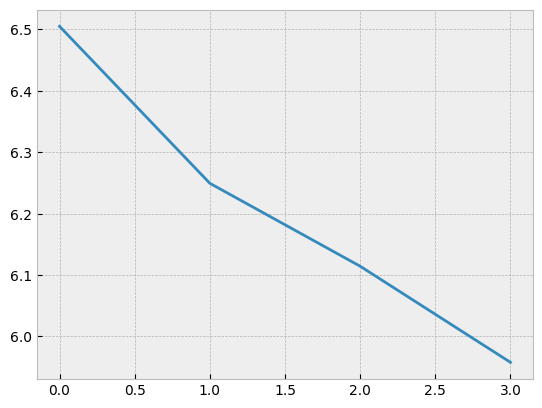

In [50]:
n_epochs = 1
n_iters = n_epochs * n_samples
print_every = n_samples // 2
plot_every = n_samples // 4
hidden_size = 500
n_layers = 3
lr = 0.001

decoder = RNN(n_tokens, hidden_size, n_tokens, n_layers)
if USE_GPU:
    decoder.cuda()
print(decoder, flush=True)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
    criterion.cuda()

all_losses = []
loss_avg = 0
all_bw = []
bw_avg = 0

iterable = range(1, n_iters + 1)
tqdm_ = tqdm(iterable, '', leave=False, dynamic_ncols=True, mininterval=1.0, ascii=True, miniters=1)
first_step = True

prime_tok = str2syl2tok('Nauka psa czystości – jak sprawnie nauczyć psa załatwiać się na dworze?')

start = time.time()

for it in tqdm_:
    epoch = 1 + it // n_samples
    loss = train(*random_training_set())       
    loss_avg += loss

    # current loss chart
    vis_update_line_chart(vis, 'loss', it, loss, it == 1)

    # bad words    
    bw = bad_words(evaluate(prime_tok, 100))
    bw_avg += bw

    # current bad words chart
    vis_update_line_chart(vis, 'bad_words', it, bw, it == 1)
    
    # progress_bar
    tqdm_.set_postfix({'epoch': f'{epoch}/{n_epochs}', 'loss': loss, 'bw': bw})
    text = f'&nbsp;<font color="red">{tqdm_}</font>'
    vis_update_text_win(vis, 'progress_bar', text)

    if it % print_every == 0:
        e_syl = evaluate(prime_tok, 1000)
        e_bw = bad_words(e_syl)
        stats_str = '\n[%s (%d %d %d%%) loss=%.4f bw=%.4f]' % (time_since(start), epoch, it, it / n_iters * 100, loss, e_bw)
        print(stats_str)
        
        e_str = fix_punctuation(decode_tokens(syl2str(e_syl, delim='')))
        e_html = format_html(e_str); display(HTML(e_html))
        print(flush=True)        
        
        text = f'<b>{stats_str}</b><br />{e_html}'
        vis_update_text_win(vis, 'evaluation', text)
        
        e_syl_path = tmp_path / 'e_syl.txt'
        e_syl_path.open('w').write(' '.join(e_syl))

    if it % plot_every == 0:
        vis_update_line_chart(vis, 'loss_avg', it, loss_avg / plot_every, first_step)
        vis_update_line_chart(vis, 'bad_words_avg', it, bw_avg / plot_every, first_step)
        all_bw.append(bw)
        bw_avg = 0
        first_step = False
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

plt.figure()
plt.plot(all_losses)

ALLTOKS, MODEL = ['all_tokens', 'model']
fn_zwyczajne_zycie1 = {ALLTOKS: f'all_tokens.n{n_tokens}.zwyczajne-zycie1.p', 
                  MODEL: f'zwyczajne-zycie1.h{hidden_size}.l{n_layers}.e{n_epochs}.gpu.torch'}
fn_dict = fn_zwyczajne_zycie1; fn_dict

# save all_tokens
all_tokens_path = tmp_path / fn_dict[ALLTOKS]
pickle.dump(all_tokens, open(all_tokens_path, 'wb'))

warnings.filterwarnings('ignore')

# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

2. Ta sama sieć, zmienione hiperparametry:
n_layers z 3 -> 6
n_epochs z 1 -> 5

RNN(
  (encoder): Embedding(5125, 500)
  (gru): GRU(500, 500, num_layers=6)
  (decoder): Linear(in_features=500, out_features=5125, bias=True)
)


 10%|9         | 232/2330 [04:41<41:41,  1.19s/it, epoch=1/5, loss=6.39, bw=0.4]  


 41s (1 233 10%) loss=6.3906 bw=0.4683]


 20%|#9        | 465/2330 [09:25<37:23,  1.20s/it, epoch=2/5, loss=6.49, bw=0.344]


 25s (2 466 20%) loss=6.4851 bw=0.4088]


 30%|##9       | 698/2330 [14:10<32:52,  1.21s/it, epoch=2/5, loss=6.43, bw=0.352]


 10s (2 699 30%) loss=6.4342 bw=0.4273]


 40%|###9      | 931/2330 [18:57<28:40,  1.23s/it, epoch=3/5, loss=6.77, bw=0.328]


 57s (3 932 40%) loss=6.7679 bw=0.4595]


 50%|####9     | 1164/2330 [23:44<24:03,  1.24s/it, epoch=3/5, loss=6.39, bw=0.344]


 45s (3 1165 50%) loss=6.3900 bw=0.4429]


 60%|#####9    | 1397/2330 [28:32<19:05,  1.23s/it, epoch=4/5, loss=6.57, bw=0.432]


 32s (4 1398 60%) loss=6.5685 bw=0.4215]


 70%|######9   | 1630/2330 [33:19<14:15,  1.22s/it, epoch=4/5, loss=6.4, bw=0.36]  


 19s (4 1631 70%) loss=6.4021 bw=0.4215]


 80%|#######9  | 1863/2330 [38:05<09:28,  1.22s/it, epoch=5/5, loss=6.42, bw=0.384]


 5s (5 1864 80%) loss=6.4241 bw=0.4449]


 90%|########9 | 2096/2330 [42:51<04:42,  1.21s/it, epoch=5/5, loss=6.56, bw=0.368]


 51s (5 2097 90%) loss=6.5614 bw=0.4488]


100%|#########9| 2329/2330 [47:35<00:01,  1.23s/it, epoch=6/5, loss=6.26, bw=0.376]


 36s (6 2330 100%) loss=6.2554 bw=0.4771]


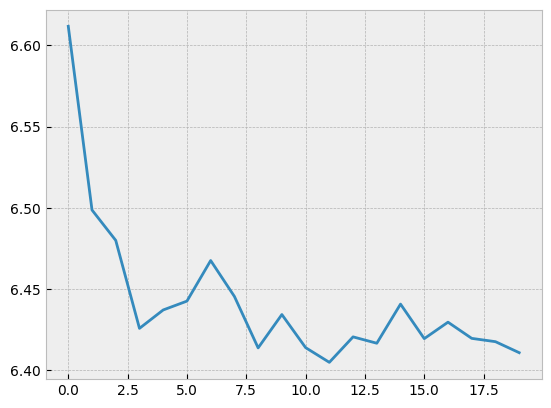

In [51]:
n_epochs = 5
n_iters = n_epochs * n_samples
print_every = n_samples // 2
plot_every = n_samples // 4
hidden_size = 500
n_layers = 6
lr = 0.001

decoder = RNN(n_tokens, hidden_size, n_tokens, n_layers)
if USE_GPU:
    decoder.cuda()
print(decoder, flush=True)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
    criterion.cuda()

all_losses = []
loss_avg = 0
all_bw = []
bw_avg = 0

iterable = range(1, n_iters + 1)
tqdm_ = tqdm(iterable, '', leave=False, dynamic_ncols=True, mininterval=1.0, ascii=True, miniters=1)
first_step = True

prime_tok = str2syl2tok('Nauka psa czystości – jak sprawnie nauczyć psa załatwiać się na dworze?')

start = time.time()

for it in tqdm_:
    epoch = 1 + it // n_samples
    loss = train(*random_training_set())       
    loss_avg += loss

    # current loss chart
    vis_update_line_chart(vis, 'loss', it, loss, it == 1)

    # bad words    
    bw = bad_words(evaluate(prime_tok, 100))
    bw_avg += bw

    # current bad words chart
    vis_update_line_chart(vis, 'bad_words', it, bw, it == 1)
    
    # progress_bar
    tqdm_.set_postfix({'epoch': f'{epoch}/{n_epochs}', 'loss': loss, 'bw': bw})
    text = f'&nbsp;<font color="red">{tqdm_}</font>'
    vis_update_text_win(vis, 'progress_bar', text)

    if it % print_every == 0:
        e_syl = evaluate(prime_tok, 1000)
        e_bw = bad_words(e_syl)
        stats_str = '\n[%s (%d %d %d%%) loss=%.4f bw=%.4f]' % (time_since(start), epoch, it, it / n_iters * 100, loss, e_bw)
        print(stats_str)
        
        e_str = fix_punctuation(decode_tokens(syl2str(e_syl, delim='')))
        e_html = format_html(e_str); display(HTML(e_html))
        print(flush=True)        
        
        text = f'<b>{stats_str}</b><br />{e_html}'
        vis_update_text_win(vis, 'evaluation', text)
        
        e_syl_path = tmp_path / 'e_syl.txt'
        e_syl_path.open('w').write(' '.join(e_syl))

    if it % plot_every == 0:
        vis_update_line_chart(vis, 'loss_avg', it, loss_avg / plot_every, first_step)
        vis_update_line_chart(vis, 'bad_words_avg', it, bw_avg / plot_every, first_step)
        all_bw.append(bw)
        bw_avg = 0
        first_step = False
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

plt.figure()
plt.plot(all_losses)


ALLTOKS, MODEL = ['all_tokens', 'model']
fn_zwyczajne_zycie2 = {ALLTOKS: f'all_tokens.n{n_tokens}.zwyczajne-zycie2.p', 
                  MODEL: f'zwyczajne-zycie2.h{hidden_size}.l{n_layers}.e{n_epochs}.gpu.torch'}
fn_dict = fn_zwyczajne_zycie2; fn_dict

# save all_tokens
all_tokens_path = tmp_path / fn_dict[ALLTOKS]
pickle.dump(all_tokens, open(all_tokens_path, 'wb'))

warnings.filterwarnings('ignore')

# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

3. Nowa sieć neuronowa z dodaną warstwą dropout (=0.1) i hiperparametrami takimi jak w przykładzie

In [52]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, dropout = 0.1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.encoder_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(to_gpu(torch.zeros(self.n_layers, 1, self.hidden_size)))

RNN(
  (encoder): Embedding(5125, 500)
  (encoder_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(500, 500, num_layers=3, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (decoder): Linear(in_features=500, out_features=5125, bias=True)
)


 50%|####9     | 231/466 [03:18<03:18,  1.18it/s, epoch=1/1, loss=5.87, bw=0.304]


 18s (1 233 50%) loss=5.8683 bw=0.3629]


100%|#########9| 465/466 [06:36<00:00,  1.18it/s, epoch=2/1, loss=5.3, bw=0.04]  


 36s (2 466 100%) loss=5.2952 bw=0.0254]


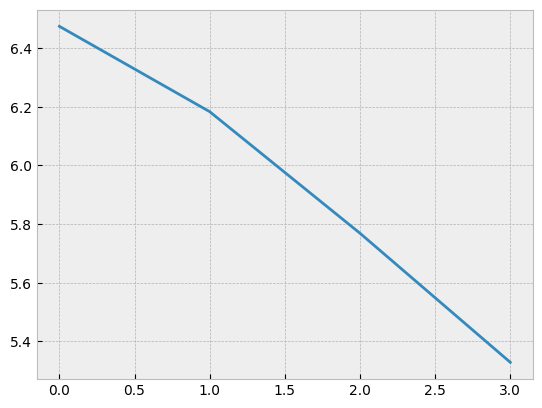

In [53]:
n_epochs = 1
n_iters = n_epochs * n_samples
print_every = n_samples // 2
plot_every = n_samples // 4
hidden_size = 500
n_layers = 3
lr = 0.001

decoder = RNN(n_tokens, hidden_size, n_tokens, n_layers)
if USE_GPU:
    decoder.cuda()
print(decoder, flush=True)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
    criterion.cuda()

all_losses = []
loss_avg = 0
all_bw = []
bw_avg = 0

iterable = range(1, n_iters + 1)
tqdm_ = tqdm(iterable, '', leave=False, dynamic_ncols=True, mininterval=1.0, ascii=True, miniters=1)
first_step = True

prime_tok = str2syl2tok('Nauka psa czystości – jak sprawnie nauczyć psa załatwiać się na dworze?')

start = time.time()

for it in tqdm_:
    epoch = 1 + it // n_samples
    loss = train(*random_training_set())       
    loss_avg += loss

    # current loss chart
    vis_update_line_chart(vis, 'loss', it, loss, it == 1)

    # bad words    
    bw = bad_words(evaluate(prime_tok, 100))
    bw_avg += bw

    # current bad words chart
    vis_update_line_chart(vis, 'bad_words', it, bw, it == 1)
    
    # progress_bar
    tqdm_.set_postfix({'epoch': f'{epoch}/{n_epochs}', 'loss': loss, 'bw': bw})
    text = f'&nbsp;<font color="red">{tqdm_}</font>'
    vis_update_text_win(vis, 'progress_bar', text)

    if it % print_every == 0:
        e_syl = evaluate(prime_tok, 1000)
        e_bw = bad_words(e_syl)
        stats_str = '\n[%s (%d %d %d%%) loss=%.4f bw=%.4f]' % (time_since(start), epoch, it, it / n_iters * 100, loss, e_bw)
        print(stats_str)
        
        e_str = fix_punctuation(decode_tokens(syl2str(e_syl, delim='')))
        e_html = format_html(e_str); display(HTML(e_html))
        print(flush=True)        
        
        text = f'<b>{stats_str}</b><br />{e_html}'
        vis_update_text_win(vis, 'evaluation', text)
        
        e_syl_path = tmp_path / 'e_syl.txt'
        e_syl_path.open('w').write(' '.join(e_syl))

    if it % plot_every == 0:
        vis_update_line_chart(vis, 'loss_avg', it, loss_avg / plot_every, first_step)
        vis_update_line_chart(vis, 'bad_words_avg', it, bw_avg / plot_every, first_step)
        all_bw.append(bw)
        bw_avg = 0
        first_step = False
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

plt.figure()
plt.plot(all_losses)

ALLTOKS, MODEL = ['all_tokens', 'model']
fn_zwyczajne_zycie3 = {ALLTOKS: f'all_tokens.n{n_tokens}.zwyczajne-zycie3.p', 
                  MODEL: f'zwyczajne-zycie3.h{hidden_size}.l{n_layers}.e{n_epochs}.gpu.torch'}
fn_dict = fn_zwyczajne_zycie3; fn_dict

# save all_tokens
all_tokens_path = tmp_path / fn_dict[ALLTOKS]
pickle.dump(all_tokens, open(all_tokens_path, 'wb'))

warnings.filterwarnings('ignore')

# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

4. Nowa sieć neuronowa z dodaną warstwą dropout (=0.1) i hiperparametrami jak w przykładzie 2.

RNN(
  (encoder): Embedding(5125, 500)
  (encoder_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(500, 500, num_layers=6, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (decoder): Linear(in_features=500, out_features=5125, bias=True)
)


 10%|9         | 232/2330 [05:01<44:26,  1.27s/it, epoch=1/5, loss=6.27, bw=0.376]


 1s (1 233 10%) loss=6.2749 bw=0.4351]


 20%|#9        | 465/2330 [10:02<39:32,  1.27s/it, epoch=2/5, loss=6.09, bw=0.312]


 2s (2 466 20%) loss=6.0949 bw=0.4234]


 30%|##9       | 698/2330 [15:04<35:51,  1.32s/it, epoch=2/5, loss=6.03, bw=0.288]


 4s (2 699 30%) loss=6.0328 bw=0.4615]


 40%|###9      | 931/2330 [20:09<30:31,  1.31s/it, epoch=3/5, loss=6.54, bw=0.312]


 10s (3 932 40%) loss=6.5355 bw=0.3951]


 50%|####9     | 1164/2330 [25:15<25:17,  1.30s/it, epoch=3/5, loss=6.66, bw=0.36] 


 15s (3 1165 50%) loss=6.6599 bw=0.4624]


 60%|#####9    | 1397/2330 [30:19<20:20,  1.31s/it, epoch=4/5, loss=6.48, bw=0.36] 


 20s (4 1398 60%) loss=6.4841 bw=0.4205]


 70%|######9   | 1630/2330 [35:27<15:19,  1.31s/it, epoch=4/5, loss=6.05, bw=0.352]


 27s (4 1631 70%) loss=6.0473 bw=0.4371]


 80%|#######9  | 1863/2330 [40:34<10:15,  1.32s/it, epoch=5/5, loss=6.48, bw=0.4]  


 35s (5 1864 80%) loss=6.4788 bw=0.4195]


 90%|########9 | 2096/2330 [45:42<05:04,  1.30s/it, epoch=5/5, loss=6.48, bw=0.488]


 43s (5 2097 90%) loss=6.4793 bw=0.4459]


100%|#########9| 2329/2330 [50:49<00:01,  1.28s/it, epoch=6/5, loss=6.01, bw=0.432]


 49s (6 2330 100%) loss=6.0118 bw=0.4078]


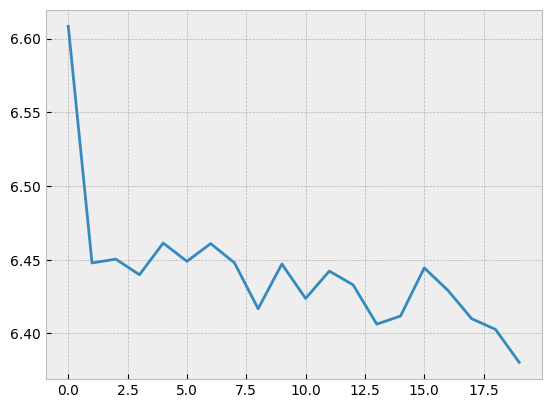

In [54]:
n_epochs = 5
n_iters = n_epochs * n_samples
print_every = n_samples // 2
plot_every = n_samples // 4
hidden_size = 500
n_layers = 6
lr = 0.001

decoder = RNN(n_tokens, hidden_size, n_tokens, n_layers)
if USE_GPU:
    decoder.cuda()
print(decoder, flush=True)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
    criterion.cuda()

all_losses = []
loss_avg = 0
all_bw = []
bw_avg = 0

iterable = range(1, n_iters + 1)
tqdm_ = tqdm(iterable, '', leave=False, dynamic_ncols=True, mininterval=1.0, ascii=True, miniters=1)
first_step = True

prime_tok = str2syl2tok('Nauka psa czystości – jak sprawnie nauczyć psa załatwiać się na dworze?')

start = time.time()

for it in tqdm_:
    epoch = 1 + it // n_samples
    loss = train(*random_training_set())       
    loss_avg += loss

    # current loss chart
    vis_update_line_chart(vis, 'loss', it, loss, it == 1)

    # bad words    
    bw = bad_words(evaluate(prime_tok, 100))
    bw_avg += bw

    # current bad words chart
    vis_update_line_chart(vis, 'bad_words', it, bw, it == 1)
    
    # progress_bar
    tqdm_.set_postfix({'epoch': f'{epoch}/{n_epochs}', 'loss': loss, 'bw': bw})
    text = f'&nbsp;<font color="red">{tqdm_}</font>'
    vis_update_text_win(vis, 'progress_bar', text)

    if it % print_every == 0:
        e_syl = evaluate(prime_tok, 1000)
        e_bw = bad_words(e_syl)
        stats_str = '\n[%s (%d %d %d%%) loss=%.4f bw=%.4f]' % (time_since(start), epoch, it, it / n_iters * 100, loss, e_bw)
        print(stats_str)
        
        e_str = fix_punctuation(decode_tokens(syl2str(e_syl, delim='')))
        e_html = format_html(e_str); display(HTML(e_html))
        print(flush=True)        
        
        text = f'<b>{stats_str}</b><br />{e_html}'
        vis_update_text_win(vis, 'evaluation', text)
        
        e_syl_path = tmp_path / 'e_syl.txt'
        e_syl_path.open('w').write(' '.join(e_syl))

    if it % plot_every == 0:
        vis_update_line_chart(vis, 'loss_avg', it, loss_avg / plot_every, first_step)
        vis_update_line_chart(vis, 'bad_words_avg', it, bw_avg / plot_every, first_step)
        all_bw.append(bw)
        bw_avg = 0
        first_step = False
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

plt.figure()
plt.plot(all_losses)

ALLTOKS, MODEL = ['all_tokens', 'model']
fn_zwyczajne_zycie4 = {ALLTOKS: f'all_tokens.n{n_tokens}.zwyczajne-zycie4.p', 
                  MODEL: f'zwyczajne-zycie4.h{hidden_size}.l{n_layers}.e{n_epochs}.gpu.torch'}
fn_dict = fn_zwyczajne_zycie4; fn_dict

# save all_tokens
all_tokens_path = tmp_path / fn_dict[ALLTOKS]
pickle.dump(all_tokens, open(all_tokens_path, 'wb'))

warnings.filterwarnings('ignore')

# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

In [55]:
ls -lah $tmp_path

total 186M
drwxr-xr-x 2 root root 4.0K Nov 28 19:15 ./
drwxr-xr-x 3 root root 4.0K Nov 28 17:09 ../
-rw-r--r-- 1 root root  81K Nov 28 17:30 all_tokens.n5125.zwyczajne-zycie1.p
-rw-r--r-- 1 root root  81K Nov 28 18:18 all_tokens.n5125.zwyczajne-zycie2.p
-rw-r--r-- 1 root root  81K Nov 28 18:25 all_tokens.n5125.zwyczajne-zycie3.p
-rw-r--r-- 1 root root  81K Nov 28 19:15 all_tokens.n5125.zwyczajne-zycie4.p
-rw-r--r-- 1 root root 5.1K Nov 28 19:15 e_syl.txt
-rw-r--r-- 1 root root   85 Nov 28 18:25 tmp_text_caps1.txt
-rw-r--r-- 1 root root  141 Nov 28 18:25 tmp_text_syl1.txt
-rw-r--r-- 1 root root  37M Nov 28 17:30 zwyczajne-zycie1.h500.l3.e1.gpu.torch
-rw-r--r-- 1 root root  54M Nov 28 18:18 zwyczajne-zycie2.h500.l6.e5.gpu.torch
-rw-r--r-- 1 root root  39M Nov 28 18:25 zwyczajne-zycie3.h500.l3.e1.gpu.torch
-rw-r--r-- 1 root root  56M Nov 28 19:15 zwyczajne-zycie4.h500.l6.e5.gpu.torch


In [56]:
n_epochs=20
ALLTOKS, MODEL = ['all_tokens', 'model']
fn_zwyczajne_zycie3 = {ALLTOKS: f'all_tokens.n5125.zwyczajne-zycie3.p', 
                  MODEL: f'zwyczajne-zycie3.h500.l3.e1.gpu.torch'}
fn_dict = fn_zwyczajne_zycie3; 
fn_dict



{'all_tokens': 'all_tokens.n5125.zwyczajne-zycie3.p',
 'model': 'zwyczajne-zycie3.h500.l3.e1.gpu.torch'}

In [57]:
if True:
  all_tokens_path = tmp_path / fn_dict[ALLTOKS]
  print(f'all_tokens_path = {all_tokens_path}')
  all_tokens = pickle.load(open(all_tokens_path, 'rb'))
  n_characters = len(all_tokens)
  tok2idx_dict = {tok: idx for (idx, tok) in enumerate(all_tokens)}

  model_path = tmp_path / fn_dict[MODEL]
  decoder = torch.load(model_path)
  decoder.gru.all_weights
  print(f'model_path = {model_path}')
  print(decoder.state_dict)

all_tokens_path = data/rnn_generator/tmp/all_tokens.n5125.zwyczajne-zycie3.p
model_path = data/rnn_generator/tmp/zwyczajne-zycie3.h500.l3.e1.gpu.torch
<bound method Module.state_dict of RNN(
  (encoder): Embedding(5125, 500)
  (encoder_dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(500, 500, num_layers=3, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (decoder): Linear(in_features=500, out_features=5125, bias=True)
)>


## Ewaluacja w różnych "temperaturach"

W powyższej funkcji `evaluate`, za każdym razem, gdy dokonywana jest prognoza, wyjścia są dzielone przez przekazany argument "temperature". Użycie większej liczby sprawia, że wszystkie akcje są bardziej jednakowo prawdopodobne, a tym samym dają nam "bardziej losowe" wyniki. Użycie mniejszej wartości (mniejszej niż 1) sprawia, że wysokie prawdopodobieństwa przyczyniają się bardziej. Gdy ustawiamy temperaturę na zero, wybieramy tylko najbardziej prawdopodobne wyjścia.

Możemy zobaczyć te efekty poprzez dostosowanie argumentu `temperature`.


In [58]:
def print_eval(e_syl):
  display(HTML(format_html(fix_punctuation(decode_tokens(syl2str(e_syl, delim=''))))))

In [59]:
prime_tok = str2syl2tok('W dość wczesnych godzinach sierpniowego, cichego, niedzielnego popołudnia Tereska Kępińska siedziała przy biurku w swoim pokoju')

In [60]:
print_eval(evaluate(prime_tok, 200, temperature=0.8))

In [61]:
print_eval(evaluate(prime_tok, 200, temperature=0.2))

In [62]:
print_eval(evaluate(prime_tok, 200, temperature=0.5))

In [63]:
print_eval(evaluate(prime_tok, 200, temperature=1.2))

In [64]:
print_eval(evaluate(prime_tok, 200, temperature=1.0))

In [65]:
print_eval(evaluate(prime_tok, 200, temperature=0.7))